## Importing libraries and dataset

In [1]:
import os
import numpy as np
import time
import datetime
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
from IPython.display import clear_output
from keras.utils.vis_utils import plot_model

tfds.disable_progress_bar()

In [2]:
from gen_disc import *

In [3]:
%load_ext tensorboard

In [4]:
dataset, metadata = tfds.load('cycle_gan/horse2zebra',
                              with_info=True, as_supervised=True)

trainA, trainB = dataset['trainA'], dataset['trainB']
testA, testB = dataset['testA'], dataset['testB']

In [5]:
print(trainA)

<PrefetchDataset shapes: ((None, None, 3), ()), types: (tf.uint8, tf.int64)>


## Dataset preprocessing

In [6]:
# Define the standard image size.
orig_img_size = (286, 286)
# Size of the random crops to be used during training.
input_img_size = (256, 256, 3)
# Weights initializer for the layers.
kernel_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)
# Gamma initializer for instance normalization.
gamma_init = keras.initializers.RandomNormal(mean=0.0, stddev=0.02)

buffer_size = 256
batch_size = 1


def normalize_img(img):
    img = tf.cast(img, dtype=tf.float32)
    # Map values in the range [-1, 1]
    return (img / 127.5) - 1.0


def preprocess_train_image(img, label):
    # Random flip
    img = tf.image.random_flip_left_right(img)
    # Resize to the original size first
    img = tf.image.resize(img, [*orig_img_size])
    # Random crop to 256X256
    img = tf.image.random_crop(img, size=[*input_img_size])
    # Normalize the pixel values in the range [-1, 1]
    img = normalize_img(img)
    return img

def preprocess_test_image(img, label):
    # Only resizing and normalization for the test images.
    img = tf.image.resize(img, [input_img_size[0], input_img_size[1]])
    img = normalize_img(img)
    return img

In [7]:
autotune = tf.data.experimental.AUTOTUNE
# Apply the preprocessing operations to the training data
trainA = (trainA.map(preprocess_train_image, num_parallel_calls=autotune).cache().shuffle(buffer_size).batch(batch_size))
trainB = (trainB.map(preprocess_train_image, num_parallel_calls=autotune).cache().shuffle(buffer_size).batch(batch_size))

# Apply the preprocessing operations to the test data
testA = (testA.map(preprocess_test_image, num_parallel_calls=autotune).cache().shuffle(buffer_size).batch(batch_size))
testB = (testB.map(preprocess_test_image, num_parallel_calls=autotune).cache().shuffle(buffer_size).batch(batch_size))


## Model Compiling

In [ ]:
"""ONLY RUN FOR RESNET IMPLEMENTATION"""

generator_g = get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    name=None,
)
generator_4 = get_resnet_generator(
    filters=64,
    num_downsampling_blocks=2,
    num_residual_blocks=9,
    num_upsample_blocks=2,
    name=None,
)

In [8]:
"""EFFICIENTNET IMPLEMENTATION"""
#dropout in middle of stack of layers or towards first or last 25% after conv
#plot structure of the model

generator_g = efficientnet_generator(name=None)
generator_f = efficientnet_generator(name=None)

Model: "functional_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
reflection_padding2d (Reflectio (None, 262, 262, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 256, 256, 64) 9408        reflection_padding2d[0][0]       
__________________________________________________________________________________________________
instance_normalization (Instanc (None, 256, 256, 64) 128         conv2d[0][0]                     
_______________________________________________________________________________________

In [9]:
discriminator_x = get_discriminator(name="discriminator_X")
discriminator_y = get_discriminator(name="discriminator_Y")

In [10]:
sampleA = next(iter(trainA))
sampleB = next(iter(trainB))

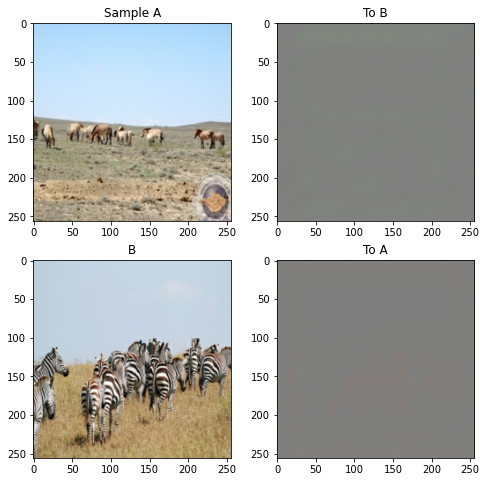

In [11]:
to_B = generator_g(sampleA)
to_A = generator_f(sampleB)
plt.figure(figsize=(8, 8))
contrast = 8

imgs = [sampleA, to_B, sampleB, to_A]
title = ['Sample A', 'To B', 'B', 'To A']

for i in range(len(imgs)):
  plt.subplot(2, 2, i+1)
  plt.title(title[i])
  if i % 2 == 0:
    plt.imshow(imgs[i][0] * 0.5 + 0.5)
  else:
    plt.imshow(imgs[i][0] * 0.5 * contrast + 0.5)
plt.show()

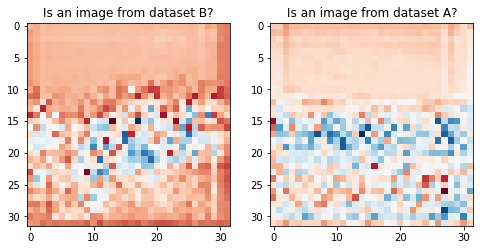

In [12]:
plt.figure(figsize=(8, 8))

plt.subplot(121)
plt.title('Is an image from dataset B?')
plt.imshow(discriminator_y(sampleB)[0, ..., -1], cmap='RdBu_r')

plt.subplot(122)
plt.title('Is an image from dataset A?')
plt.imshow(discriminator_x(sampleA)[0, ..., -1], cmap='RdBu_r')

plt.show()

## Defining losses

In [13]:
LAMBDA = 10
loss_obj = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [14]:
def discriminator_loss(real, generated):
  real_loss = loss_obj(tf.ones_like(real), real)

  generated_loss = loss_obj(tf.zeros_like(generated), generated)

  total_disc_loss = real_loss + generated_loss

  return total_disc_loss * 0.5

In [15]:
def generator_loss(generated):
  return loss_obj(tf.ones_like(generated), generated)

In [16]:
def mae(real_image, cycled_image):
  loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
  
  return LAMBDA * loss1

In [17]:
def identity_loss(real_image, same_image):
  loss = tf.reduce_mean(tf.abs(real_image - same_image))
  return LAMBDA * 0.5 * loss

In [18]:
generator_g_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
generator_f_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

discriminator_x_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)
discriminator_y_optimizer = tf.keras.optimizers.Adam(2e-4, beta_1=0.5)

## Saving checkpoints

In [19]:
checkpoint_path = "./checkpoints/train"

ckpt = tf.train.Checkpoint(generator_g=generator_g,
                           generator_f=generator_f,
                           discriminator_x=discriminator_x,
                           discriminator_y=discriminator_y,
                           generator_g_optimizer=generator_g_optimizer,
                           generator_f_optimizer=generator_f_optimizer,
                           discriminator_x_optimizer=discriminator_x_optimizer,
                           discriminator_y_optimizer=discriminator_y_optimizer)

ckpt_manager = tf.train.CheckpointManager(ckpt, checkpoint_path, max_to_keep=5)

# if a checkpoint exists, restore the latest checkpoint.
if ckpt_manager.latest_checkpoint:
  ckpt.restore(ckpt_manager.latest_checkpoint)
  print ('Latest checkpoint restored!!')

In [20]:
def generate_images(model, test_input):
  prediction = model(test_input)
    
  plt.figure(figsize=(12, 12))

  display_list = [test_input[0], prediction[0]]
  title = ['Input Image', 'Predicted Image']

  for i in range(2):
    plt.subplot(1, 2, i+1)
    plt.title(title[i])
    # getting the pixel values between [0, 1] to plot.
    plt.imshow(display_list[i] * 0.5 + 0.5)
    plt.axis('off')
  plt.show()

In [21]:
log_dir="logs/fit/"

summary_writer = tf.summary.create_file_writer(log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

In [ ]:
%tensorboard --logdir logs/fit 

In [ ]:
# --host 127.0.0.1

## Training

In [28]:
@tf.function
def train_step(real_x, real_y, epoch):
  # persistent is set to True because the tape is used more than once to calculate the gradients.
  with tf.GradientTape(persistent=True) as tape:
    # Generator G translates X -> Y
    # Generator F translates Y -> X.
    
    """TRAINING"""

    fake_y = generator_g(real_x, training=True)
    cycled_x = generator_f(fake_y, training=True)

    fake_x = generator_f(real_y, training=True)
    cycled_y = generator_g(fake_x, training=True)

    # same_x and same_y are used for identity loss.
    same_x = generator_f(real_x, training=True)
    same_y = generator_g(real_y, training=True)

    disc_real_x = discriminator_x(real_x, training=True)
    disc_real_y = discriminator_y(real_y, training=True)

    disc_fake_x = discriminator_x(fake_x, training=True)
    disc_fake_y = discriminator_y(fake_y, training=True)

    """CALCULATING LOSSES"""

    # calculate generator the loss with binary crossentropy
    gen_g_loss = generator_loss(disc_fake_y)
    gen_f_loss = generator_loss(disc_fake_x)
    

    #calculating separate mean average errors for x and y images
    x_cycle_loss = mae(real_x, cycled_x)
    y_cycle_loss = mae(real_y, cycled_y)

    #calculating the total mean average error (both x and y images)
    total_cycle_loss = mae(real_x, cycled_x) + mae(real_y, cycled_y)

    #total generator loss = adversarial loss + cycle loss
    total_gen_g_loss = gen_g_loss + total_cycle_loss + identity_loss(real_y, same_y)
    total_gen_f_loss = gen_f_loss + total_cycle_loss + identity_loss(real_x, same_x)

    disc_x_loss = discriminator_loss(disc_real_x, disc_fake_x)
    disc_y_loss = discriminator_loss(disc_real_y, disc_fake_y)


  """CALCULATING GRADIENT UPDATES"""

  #gradients for generator and discriminator
  generator_g_gradients = tape.gradient(total_gen_g_loss, 
                                        generator_g.trainable_variables)
  generator_f_gradients = tape.gradient(total_gen_f_loss, 
                                        generator_f.trainable_variables)
  
  discriminator_x_gradients = tape.gradient(disc_x_loss, 
                                            discriminator_x.trainable_variables)
  discriminator_y_gradients = tape.gradient(disc_y_loss, 
                                            discriminator_y.trainable_variables)

  """APPLYING GRADIENT UPDATES"""
  
  generator_g_optimizer.apply_gradients(zip(generator_g_gradients, 
                                            generator_g.trainable_variables))

  generator_f_optimizer.apply_gradients(zip(generator_f_gradients, 
                                            generator_f.trainable_variables))
  
  discriminator_x_optimizer.apply_gradients(zip(discriminator_x_gradients,
                                                discriminator_x.trainable_variables))
  
  discriminator_y_optimizer.apply_gradients(zip(discriminator_y_gradients,
                                                discriminator_y.trainable_variables))

  """WRITING LOSSES FOR TENSORBOARD"""

  with summary_writer.as_default():
    tf.summary.scalar('mae_x', x_cycle_loss, step=epoch)
    tf.summary.scalar('mae_y', y_cycle_loss, step=epoch)
    tf.summary.scalar('total_cycle_loss', total_cycle_loss, step=epoch)
    tf.summary.scalar('total_gen_g_loss', total_gen_g_loss, step=epoch)
    tf.summary.scalar('total_gen_f_loss', total_gen_f_loss, step=epoch)
    tf.summary.scalar('disc_x_loss', disc_x_loss, step=epoch)
    tf.summary.scalar('disc_y_loss', disc_y_loss, step=epoch)
 

In [29]:
EPOCHS = 20

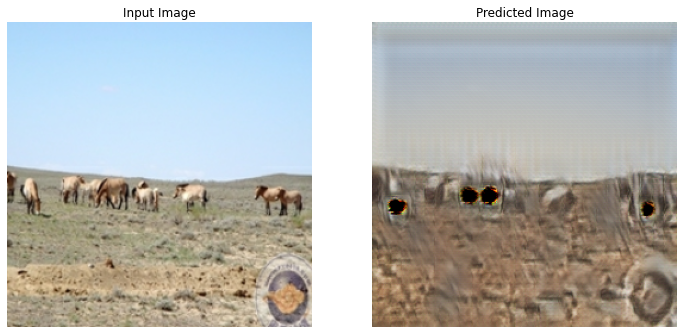

Saving checkpoint for epoch 20 at ./checkpoints/train\ckpt-4
Time taken for epoch 20 is 402.3110089302063 sec



In [30]:
for epoch in range(EPOCHS):
  start = time.time()
  n = 0
  for image_x, image_y in tf.data.Dataset.zip((trainA, trainB)):
    train_step(image_x, image_y, epoch)
    if n % 10 == 0:
      print ('*', end=' ')
    n += 1

  clear_output(wait=True)
  # Using a consistent image (sampleA) so that the progress of the model
  # is clearly visible.
  generate_images(generator_g, sampleA)

  if (epoch + 1) % 5 == 0:
    ckpt_save_path = ckpt_manager.save()
    print ('Saving checkpoint for epoch {} at {}'.format(epoch+1,
                                                         ckpt_save_path))

  print ('Time taken for epoch {} is {} sec\n'.format(epoch + 1,
                                                      time.time()-start))


In [ ]:
efficientnet_generator.intermediate()

## Testing

In [ ]:
#this cell has to be stopped manually
!tensorboard dev upload \
  --logdir logs/fit \
  --name "My latest experiment" \
  --description "" \
  --one_shot

full model, no dropout, 6 blocks, 20 epochs - 
https://tensorboard.dev/experiment/ug9dNuXbRZmQYxQpeQm3mg/#scalars </br>

full model, dropout in first 25%, 6 blocks, 20 epochs - https://tensorboard.dev/experiment/W6aNRCwlRYeEzwoTVpvVMQ/#scalars

In [ ]:
!tensorboard dev delete --experiment_id #experiment_id_here

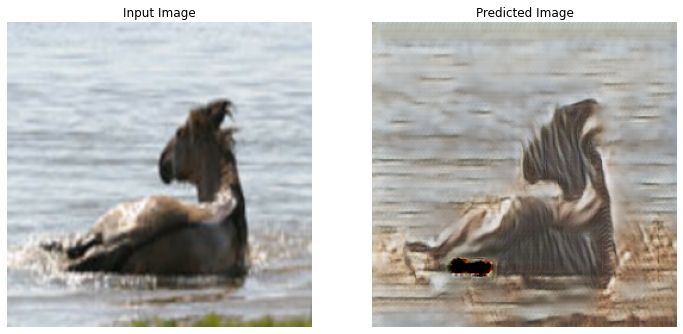

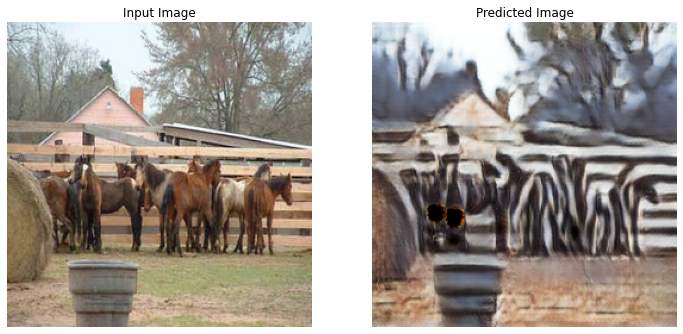

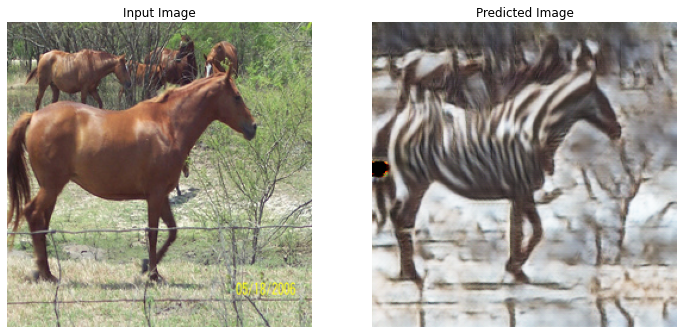

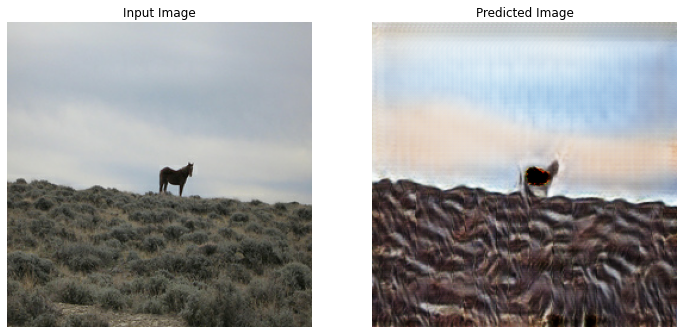

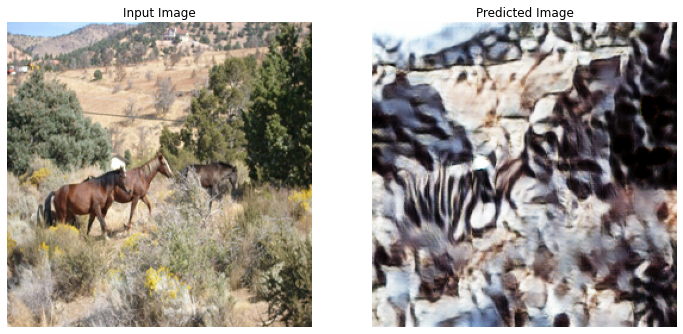

In [36]:
for img in testA.take(5):
  generate_images(generator_g, img)